Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='baseline'
    debug=False  # False
    wandb=True
    resume = None  # [None, 'auto', 'allow', 'must']
    save_checkpoint = True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = '""'  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [ ]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.10.2+cu111
Python 3.7.13

Mon May 30 14:00:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |   8131MiB / 16280MiB |      0%      Default |
|                

In [ ]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 54.6 ms, sys: 320 ms, total: 375 ms
Wall time: 4.12 s


In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        anonymous=anony)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.10.2+cu111
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

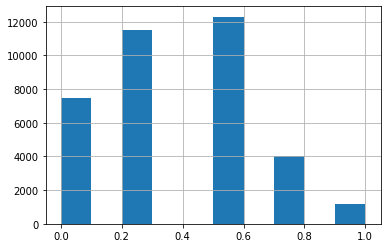

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [ ]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133
max_len: 133


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed and (checkpoint['epoch'] < CFG.epochs - 1):  # foldの終わりで止まっている時もある
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========
========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifi

Epoch: [1][0/1693] Elapsed 0m 1s (remain 42m 21s) Loss: 0.6870(0.6870) Grad: 190487.1719  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 39s (remain 26m 9s) Loss: 0.5370(0.6348) Grad: 57126.7227  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 3m 17s (remain 24m 26s) Loss: 0.6084(0.6143) Grad: 84202.2578  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 4m 55s (remain 22m 47s) Loss: 0.5914(0.6016) Grad: 74303.5312  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 6m 33s (remain 21m 8s) Loss: 0.6361(0.5942) Grad: 69089.4453  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 8m 11s (remain 19m 29s) Loss: 0.3984(0.5845) Grad: 93168.9141  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 9m 49s (remain 17m 51s) Loss: 0.6023(0.5774) Grad: 38382.3945  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 11m 27s (remain 16m 13s) Loss: 0.5604(0.5740) Grad: 78898.8203  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 13m 5s (remain 14m 34s) Loss: 0.5750(0.5717) Grad: 37007.1211  LR: 0.00001932  
Epoch: [1][900/1693] E

Epoch 1 - avg_train_loss: 0.5570  avg_val_loss: 0.5433  time: 1844s
Epoch 1 - avg_train_loss: 0.5570  avg_val_loss: 0.5433  time: 1844s
Epoch 1 - Score: 0.8306
Epoch 1 - Score: 0.8306
Epoch 1 - Save Best Score: 0.8306 Model
Epoch 1 - Save Best Score: 0.8306 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 49m 1s) Loss: 0.5599(0.5599) Grad: 122761.7500  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 41s (remain 26m 32s) Loss: 0.5975(0.5188) Grad: 163621.7969  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 3m 18s (remain 24m 36s) Loss: 0.4065(0.5203) Grad: 49612.1836  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 4m 56s (remain 22m 52s) Loss: 0.5365(0.5171) Grad: 304972.2188  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 6m 34s (remain 21m 11s) Loss: 0.5156(0.5170) Grad: 62535.0664  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 8m 12s (remain 19m 32s) Loss: 0.5579(0.5162) Grad: 45995.1172  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 9m 50s (remain 17m 52s) Loss: 0.4815(0.5172) Grad: 80569.1328  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 11m 28s (remain 16m 14s) Loss: 0.6265(0.5162) Grad: 76595.8359  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 13m 6s (remain 14m 36s) Loss: 0.6363(0.5180) Grad: 105527.6562  LR: 0.00001402  
Epoch: [2][900/169

Epoch 2 - avg_train_loss: 0.5186  avg_val_loss: 0.5438  time: 1844s
Epoch 2 - avg_train_loss: 0.5186  avg_val_loss: 0.5438  time: 1844s
Epoch 2 - Score: 0.8411
Epoch 2 - Score: 0.8411
Epoch 2 - Save Best Score: 0.8411 Model
Epoch 2 - Save Best Score: 0.8411 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 49m 55s) Loss: 0.5457(0.5457) Grad: 33316.0156  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 40s (remain 26m 30s) Loss: 0.3983(0.5032) Grad: 40162.6992  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 3m 18s (remain 24m 35s) Loss: 0.5155(0.5010) Grad: 64322.2422  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 4m 56s (remain 22m 53s) Loss: 0.5404(0.5016) Grad: 67518.8125  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 6m 34s (remain 21m 12s) Loss: 0.5138(0.5027) Grad: 30145.8281  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 8m 12s (remain 19m 32s) Loss: 0.5139(0.5019) Grad: 90395.4688  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 9m 50s (remain 17m 53s) Loss: 0.5076(0.5028) Grad: 101068.9688  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 11m 28s (remain 16m 14s) Loss: 0.4519(0.5031) Grad: 46834.7539  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 13m 6s (remain 14m 35s) Loss: 0.4852(0.5052) Grad: 136792.2031  LR: 0.00000637  
Epoch: [3][900/1693

Epoch 3 - avg_train_loss: 0.5044  avg_val_loss: 0.5564  time: 1844s
Epoch 3 - avg_train_loss: 0.5044  avg_val_loss: 0.5564  time: 1844s
Epoch 3 - Score: 0.8384
Epoch 3 - Score: 0.8384


Epoch: [4][0/1693] Elapsed 0m 1s (remain 36m 19s) Loss: 0.3941(0.3941) Grad: 12047.8682  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 40s (remain 26m 18s) Loss: 0.4609(0.5053) Grad: 99539.7969  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 3m 18s (remain 24m 30s) Loss: 0.5060(0.5015) Grad: 66176.6250  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 4m 56s (remain 22m 48s) Loss: 0.5399(0.5002) Grad: 31154.0469  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 6m 33s (remain 21m 9s) Loss: 0.5698(0.4984) Grad: 444491.4375  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 8m 11s (remain 19m 30s) Loss: 0.6031(0.4985) Grad: 70871.5859  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 9m 49s (remain 17m 51s) Loss: 0.6437(0.4985) Grad: 48076.9688  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 11m 27s (remain 16m 12s) Loss: 0.4766(0.4970) Grad: 95855.4609  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 13m 5s (remain 14m 34s) Loss: 0.3934(0.4961) Grad: 37090.2695  LR: 0.00000085  
Epoch: [4][900/1693] 

Epoch 4 - avg_train_loss: 0.4967  avg_val_loss: 0.5637  time: 1843s
Epoch 4 - avg_train_loss: 0.4967  avg_val_loss: 0.5637  time: 1843s
Epoch 4 - Score: 0.8374
Epoch 4 - Score: 0.8374


EVAL: [586/587] Elapsed 3m 3s (remain 0m 0s) Loss: 0.6641(0.5637) 


========== fold: 0 result ==========
========== fold: 0 result ==========
Score: 0.8411
Score: 0.8411
========== fold: 1 training ==========
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the

Epoch: [1][0/1725] Elapsed 0m 1s (remain 44m 47s) Loss: 0.7504(0.7504) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 40s (remain 26m 55s) Loss: 0.6583(0.6416) Grad: 30422.8828  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 3m 18s (remain 25m 3s) Loss: 0.5976(0.6225) Grad: 35031.6250  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 4m 56s (remain 23m 21s) Loss: 0.6128(0.6081) Grad: 20835.5430  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 6m 34s (remain 21m 41s) Loss: 0.6085(0.5974) Grad: 37638.6367  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 8m 11s (remain 20m 1s) Loss: 0.5147(0.5894) Grad: 22278.7910  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 9m 49s (remain 18m 23s) Loss: 0.5431(0.5849) Grad: 13539.8164  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 11m 27s (remain 16m 44s) Loss: 0.5502(0.5814) Grad: 36451.0781  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 13m 5s (remain 15m 6s) Loss: 0.4862(0.5766) Grad: 27568.6250  LR: 0.00001934  
Epoch: [1][900/1725] Elapsed 14

Epoch 1 - avg_train_loss: 0.5620  avg_val_loss: 0.5584  time: 1864s
Epoch 1 - avg_train_loss: 0.5620  avg_val_loss: 0.5584  time: 1864s
Epoch 1 - Score: 0.8013
Epoch 1 - Score: 0.8013
Epoch 1 - Save Best Score: 0.8013 Model
Epoch 1 - Save Best Score: 0.8013 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 49m 24s) Loss: 0.4679(0.4679) Grad: 30557.9512  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 41s (remain 27m 7s) Loss: 0.6141(0.5320) Grad: 166545.1719  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 3m 20s (remain 25m 20s) Loss: 0.4761(0.5278) Grad: 106074.1562  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 5m 0s (remain 23m 40s) Loss: 0.5438(0.5280) Grad: 49130.3125  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 6m 38s (remain 21m 54s) Loss: 0.5001(0.5243) Grad: 147483.0312  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 8m 16s (remain 20m 13s) Loss: 0.6207(0.5217) Grad: 331006.4062  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 9m 54s (remain 18m 31s) Loss: 0.3860(0.5211) Grad: 79963.3438  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 11m 32s (remain 16m 51s) Loss: 0.5803(0.5183) Grad: 41639.1484  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 13m 10s (remain 15m 11s) Loss: 0.5980(0.5179) Grad: 113360.8594  LR: 0.00001409  
Epoch: [2][900/17

Epoch 2 - avg_train_loss: 0.5171  avg_val_loss: 0.5567  time: 1869s
Epoch 2 - avg_train_loss: 0.5171  avg_val_loss: 0.5567  time: 1869s
Epoch 2 - Score: 0.8175
Epoch 2 - Score: 0.8175


EVAL: [553/554] Elapsed 2m 52s (remain 0m 0s) Loss: 0.5138(0.5567) 


Epoch 2 - Save Best Score: 0.8175 Model
Epoch 2 - Save Best Score: 0.8175 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 51m 47s) Loss: 0.6042(0.6042) Grad: 276798.3438  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 41s (remain 27m 6s) Loss: 0.4452(0.5106) Grad: 60546.2617  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 3m 19s (remain 25m 9s) Loss: 0.4698(0.5128) Grad: 48982.1953  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 4m 57s (remain 23m 25s) Loss: 0.4968(0.5143) Grad: 82898.8125  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 6m 35s (remain 21m 44s) Loss: 0.4588(0.5155) Grad: 61396.1484  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 8m 13s (remain 20m 4s) Loss: 0.5898(0.5125) Grad: 238401.3281  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 9m 51s (remain 18m 25s) Loss: 0.4835(0.5101) Grad: 70404.1719  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 11m 28s (remain 16m 46s) Loss: 0.5401(0.5106) Grad: 140315.6562  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 13m 6s (remain 15m 7s) Loss: 0.5220(0.5097) Grad: 122678.3594  LR: 0.00000644  
Epoch: [3][900/1725] 

Epoch 3 - avg_train_loss: 0.5067  avg_val_loss: 0.5638  time: 1865s
Epoch 3 - avg_train_loss: 0.5067  avg_val_loss: 0.5638  time: 1865s
Epoch 3 - Score: 0.8199
Epoch 3 - Score: 0.8199
Epoch 3 - Save Best Score: 0.8199 Model
Epoch 3 - Save Best Score: 0.8199 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 45m 44s) Loss: 0.4646(0.4646) Grad: 44025.3750  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 40s (remain 27m 3s) Loss: 0.5924(0.5054) Grad: 41688.2695  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 3m 18s (remain 25m 7s) Loss: 0.3032(0.5052) Grad: 49432.1445  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 4m 56s (remain 23m 23s) Loss: 0.5809(0.5056) Grad: 72822.6641  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 6m 34s (remain 21m 42s) Loss: 0.4165(0.5050) Grad: 18217.8477  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 8m 12s (remain 20m 3s) Loss: 0.4951(0.5057) Grad: 32371.6621  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 9m 50s (remain 18m 24s) Loss: 0.5057(0.5054) Grad: 73429.4141  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 11m 28s (remain 16m 45s) Loss: 0.4589(0.5045) Grad: 61363.7383  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 13m 6s (remain 15m 6s) Loss: 0.4947(0.5045) Grad: 101701.7812  LR: 0.00000088  
Epoch: [4][900/1725] Ela

Epoch 4 - avg_train_loss: 0.5006  avg_val_loss: 0.5694  time: 1865s
Epoch 4 - avg_train_loss: 0.5006  avg_val_loss: 0.5694  time: 1865s
Epoch 4 - Score: 0.8183
Epoch 4 - Score: 0.8183


EVAL: [553/554] Elapsed 2m 52s (remain 0m 0s) Loss: 0.5152(0.5694) 


========== fold: 1 result ==========
========== fold: 1 result ==========
Score: 0.8199
Score: 0.8199
========== fold: 2 training ==========
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the

Epoch: [1][0/1741] Elapsed 0m 1s (remain 46m 25s) Loss: 0.6760(0.6760) Grad: 139303.6719  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 40s (remain 27m 9s) Loss: 0.6930(0.6512) Grad: 67348.6641  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 3m 18s (remain 25m 19s) Loss: 0.5357(0.6155) Grad: 62049.2266  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 4m 56s (remain 23m 37s) Loss: 0.5623(0.6004) Grad: 55555.4805  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 6m 34s (remain 21m 56s) Loss: 0.6038(0.5908) Grad: 53543.2070  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 8m 11s (remain 20m 17s) Loss: 0.6016(0.5864) Grad: 109811.1250  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 9m 49s (remain 18m 38s) Loss: 0.6210(0.5822) Grad: 35081.9570  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 11m 27s (remain 17m 0s) Loss: 0.5906(0.5788) Grad: 15961.7158  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 13m 5s (remain 15m 21s) Loss: 0.4459(0.5771) Grad: 19222.3809  LR: 0.00001935  
Epoch: [1][900/1741] 

Epoch 1 - avg_train_loss: 0.5675  avg_val_loss: 0.5420  time: 1874s
Epoch 1 - avg_train_loss: 0.5675  avg_val_loss: 0.5420  time: 1874s
Epoch 1 - Score: 0.8202
Epoch 1 - Score: 0.8202


EVAL: [538/539] Elapsed 2m 48s (remain 0m 0s) Loss: 0.3661(0.5420) 


Epoch 1 - Save Best Score: 0.8202 Model
Epoch 1 - Save Best Score: 0.8202 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 54m 20s) Loss: 0.3807(0.3807) Grad: 89966.2812  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 41s (remain 27m 29s) Loss: 0.5213(0.5269) Grad: 66592.3672  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 3m 19s (remain 25m 29s) Loss: 0.5168(0.5214) Grad: 106568.7891  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 4m 57s (remain 23m 43s) Loss: 0.5335(0.5220) Grad: 56443.9688  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 6m 35s (remain 22m 1s) Loss: 0.3726(0.5196) Grad: 57731.7656  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 8m 13s (remain 20m 20s) Loss: 0.5084(0.5200) Grad: 26390.3770  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 9m 51s (remain 18m 41s) Loss: 0.6250(0.5188) Grad: 34268.6836  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 11m 29s (remain 17m 2s) Loss: 0.5140(0.5197) Grad: 28011.0625  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 13m 7s (remain 15m 23s) Loss: 0.5456(0.5201) Grad: 31676.9668  LR: 0.00001412  
Epoch: [2][900/1741] E

Epoch 2 - avg_train_loss: 0.5239  avg_val_loss: 0.5404  time: 1876s
Epoch 2 - avg_train_loss: 0.5239  avg_val_loss: 0.5404  time: 1876s
Epoch 2 - Score: 0.8369
Epoch 2 - Score: 0.8369


EVAL: [538/539] Elapsed 2m 48s (remain 0m 0s) Loss: 0.3605(0.5404) 


Epoch 2 - Save Best Score: 0.8369 Model
Epoch 2 - Save Best Score: 0.8369 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 51m 2s) Loss: 0.6011(0.6011) Grad: 176900.2969  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 41s (remain 27m 23s) Loss: 0.5041(0.5067) Grad: 48827.0820  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 3m 19s (remain 25m 25s) Loss: 0.5490(0.5104) Grad: 89250.8203  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 4m 57s (remain 23m 41s) Loss: 0.5012(0.5068) Grad: 112100.7812  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 6m 35s (remain 22m 0s) Loss: 0.5276(0.5072) Grad: 70507.6172  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 8m 13s (remain 20m 20s) Loss: 0.4738(0.5085) Grad: 215174.8906  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 9m 51s (remain 18m 41s) Loss: 0.5803(0.5097) Grad: 53986.0469  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 11m 28s (remain 17m 2s) Loss: 0.6446(0.5090) Grad: 43308.0781  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 13m 6s (remain 15m 23s) Loss: 0.6143(0.5106) Grad: 38297.9062  LR: 0.00000647  
Epoch: [3][900/1741] 

Epoch 3 - avg_train_loss: 0.5138  avg_val_loss: 0.5416  time: 1876s
Epoch 3 - avg_train_loss: 0.5138  avg_val_loss: 0.5416  time: 1876s
Epoch 3 - Score: 0.8388
Epoch 3 - Score: 0.8388


EVAL: [538/539] Elapsed 2m 48s (remain 0m 0s) Loss: 0.3497(0.5416) 


Epoch 3 - Save Best Score: 0.8388 Model
Epoch 3 - Save Best Score: 0.8388 Model


Epoch: [4][0/1741] Elapsed 0m 1s (remain 54m 46s) Loss: 0.4921(0.4921) Grad: 182814.8750  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 41s (remain 27m 26s) Loss: 0.5228(0.5044) Grad: 39389.7656  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 3m 19s (remain 25m 27s) Loss: 0.5588(0.5076) Grad: 233552.0781  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 4m 57s (remain 23m 42s) Loss: 0.5331(0.5075) Grad: 41656.4297  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 6m 35s (remain 22m 0s) Loss: 0.5738(0.5093) Grad: 25018.0742  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 8m 13s (remain 20m 20s) Loss: 0.4846(0.5087) Grad: 42216.0703  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 9m 50s (remain 18m 40s) Loss: 0.4390(0.5085) Grad: 30364.1895  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 11m 28s (remain 17m 1s) Loss: 0.4529(0.5091) Grad: 19069.4512  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 13m 6s (remain 15m 23s) Loss: 0.6311(0.5093) Grad: 435502.9688  LR: 0.00000089  
Epoch: [4][900/1741]

Epoch 4 - avg_train_loss: 0.5102  avg_val_loss: 0.5434  time: 1876s
Epoch 4 - avg_train_loss: 0.5102  avg_val_loss: 0.5434  time: 1876s
Epoch 4 - Score: 0.8388
Epoch 4 - Score: 0.8388


EVAL: [538/539] Elapsed 2m 48s (remain 0m 0s) Loss: 0.3468(0.5434) 


Epoch 4 - Save Best Score: 0.8388 Model
Epoch 4 - Save Best Score: 0.8388 Model
========== fold: 2 result ==========
========== fold: 2 result ==========
Score: 0.8388
Score: 0.8388
========== fold: 3 training ==========
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTrainin

Epoch: [1][0/1678] Elapsed 0m 1s (remain 41m 23s) Loss: 0.7799(0.7799) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 41s (remain 26m 24s) Loss: 0.6031(0.6461) Grad: 52469.0664  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 3m 19s (remain 24m 25s) Loss: 0.5931(0.6168) Grad: 47508.5352  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 4m 57s (remain 22m 40s) Loss: 0.5869(0.5969) Grad: 32133.4414  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 6m 35s (remain 20m 59s) Loss: 0.5359(0.5882) Grad: 32470.8086  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 8m 13s (remain 19m 18s) Loss: 0.5638(0.5831) Grad: 15136.1377  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 9m 51s (remain 17m 39s) Loss: 0.6087(0.5782) Grad: 29415.4102  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 11m 29s (remain 16m 0s) Loss: 0.6338(0.5734) Grad: 31433.3105  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 13m 7s (remain 14m 21s) Loss: 0.4382(0.5688) Grad: 10829.3916  LR: 0.00001931  
Epoch: [1][900/1678] Elapsed 

Epoch 1 - avg_train_loss: 0.5573  avg_val_loss: 0.5591  time: 1835s
Epoch 1 - avg_train_loss: 0.5573  avg_val_loss: 0.5591  time: 1835s
Epoch 1 - Score: 0.7969
Epoch 1 - Score: 0.7969
Epoch 1 - Save Best Score: 0.7969 Model
Epoch 1 - Save Best Score: 0.7969 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 53m 13s) Loss: 0.4750(0.4750) Grad: 24944.8164  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 41s (remain 26m 24s) Loss: 0.5969(0.5210) Grad: 443118.8125  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 3m 19s (remain 24m 25s) Loss: 0.5722(0.5170) Grad: 104985.3594  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 4m 57s (remain 22m 40s) Loss: 0.6028(0.5139) Grad: 91544.9062  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 6m 35s (remain 20m 59s) Loss: 0.5800(0.5121) Grad: 30816.7617  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 8m 13s (remain 19m 18s) Loss: 0.5404(0.5141) Grad: 27182.1426  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 9m 51s (remain 17m 39s) Loss: 0.5573(0.5145) Grad: 81855.9844  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 11m 29s (remain 16m 0s) Loss: 0.6319(0.5153) Grad: 122808.0391  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 13m 7s (remain 14m 21s) Loss: 0.5213(0.5155) Grad: 353970.2812  LR: 0.00001399  
Epoch: [2][900/167

Epoch 2 - avg_train_loss: 0.5174  avg_val_loss: 0.5634  time: 1834s
Epoch 2 - avg_train_loss: 0.5174  avg_val_loss: 0.5634  time: 1834s
Epoch 2 - Score: 0.8024
Epoch 2 - Score: 0.8024
Epoch 2 - Save Best Score: 0.8024 Model
Epoch 2 - Save Best Score: 0.8024 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 46m 54s) Loss: 0.5116(0.5116) Grad: 37400.3867  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 41s (remain 26m 18s) Loss: 0.5487(0.5108) Grad: 72159.0781  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 3m 19s (remain 24m 22s) Loss: 0.4326(0.5071) Grad: 134234.7344  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 4m 56s (remain 22m 38s) Loss: 0.5520(0.5054) Grad: 63119.4648  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 6m 34s (remain 20m 57s) Loss: 0.5009(0.5047) Grad: 104583.7344  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 8m 12s (remain 19m 17s) Loss: 0.4326(0.5049) Grad: 38023.6641  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 9m 50s (remain 17m 38s) Loss: 0.4379(0.5045) Grad: 45066.9961  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 11m 28s (remain 16m 0s) Loss: 0.4953(0.5053) Grad: 74091.4531  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 13m 6s (remain 14m 21s) Loss: 0.5977(0.5046) Grad: 35279.8438  LR: 0.00000634  
Epoch: [3][900/1678]

Epoch 3 - avg_train_loss: 0.5046  avg_val_loss: 0.5626  time: 1834s
Epoch 3 - avg_train_loss: 0.5046  avg_val_loss: 0.5626  time: 1834s
Epoch 3 - Score: 0.8094
Epoch 3 - Score: 0.8094
Epoch 3 - Save Best Score: 0.8094 Model
Epoch 3 - Save Best Score: 0.8094 Model


Epoch: [4][0/1678] Elapsed 0m 1s (remain 40m 18s) Loss: 0.5713(0.5713) Grad: 30261.3984  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 40s (remain 26m 16s) Loss: 0.4203(0.5034) Grad: 45206.6992  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 3m 19s (remain 24m 23s) Loss: 0.5897(0.5034) Grad: 50239.3047  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 4m 57s (remain 22m 39s) Loss: 0.5005(0.5003) Grad: 39132.4805  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 6m 34s (remain 20m 57s) Loss: 0.4289(0.4997) Grad: 59755.9336  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 8m 12s (remain 19m 18s) Loss: 0.6157(0.4958) Grad: 356921.1562  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 9m 50s (remain 17m 38s) Loss: 0.5174(0.4963) Grad: 31808.1465  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 11m 28s (remain 15m 59s) Loss: 0.4398(0.4950) Grad: 54884.9180  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 13m 6s (remain 14m 21s) Loss: 0.5436(0.4956) Grad: 69413.8203  LR: 0.00000083  
Epoch: [4][900/1678]

Epoch 4 - avg_train_loss: 0.4983  avg_val_loss: 0.5705  time: 1834s
Epoch 4 - avg_train_loss: 0.4983  avg_val_loss: 0.5705  time: 1834s
Epoch 4 - Score: 0.8069
Epoch 4 - Score: 0.8069
========== fold: 3 result ==========
========== fold: 3 result ==========
Score: 0.8094
Score: 0.8094
========== CV ==========
========== CV ==========
Score: 0.8266
Score: 0.8266


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▁▁▅█
[fold0] epoch,▁▃▆█
[fold0] loss,▇▇▆▆▆▆█▇▅▇▅▆▅▄▆▄▄▆▄▅▂▇▄▅▄▄▄▆▃▂▅▆▂▅▅▃▁▁▅▄
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁█▆▆
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▂▁▅█
[fold1] epoch,▁▃▆█
[fold1] loss,█▅█▅▄▄▅▆▃▁▄▄▄▄▆▁▂▂▅▄▄▄▃▆▃▃▄▄▅▄▆▄▄▂▄▄▄▄▄▁
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [ ]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 5.44k/5.44k [00:02<00:00, 2.67kB/s]
Upload successful: train.log (5KB)
Starting upload for file baselinecpc_texts.pth
100% 13.9k/13.9k [00:01<00:00, 11.5kB/s]
Upload successful: baselinecpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:02<00:00, 1.11MB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:01<00:00, 8.03kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:01<00:00, 1.41kB/s]
Upload successful: config.pth (2KB)
Starting upload for file checkpoint.pth
100% 4.86G/4.86G [01:22<00:00, 63.0MB/s]
Upload successful: checkpoint.pth (5GB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:19<00:00, 88.3MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file oof.pth
100% 7.71M/7.71M [00:01<00:00, 6.85MB/s]
Upload successful: oof.pth (8MB